In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import re

from statannot import add_stat_annotation
from modules.graphics_handler import adjust_box_widths, boxplot_hue
from modules.data_loader import file_extraction, file_folder_creator,stat_out

Step 1. Import data from excel-file

In [3]:
data = pd.read_excel('data\\neuro_count.xlsx')
data.head()

,CA1,CA3,Hilus,DG,Group
0,15.50802,9.30233,15.555560,26.206900,Контроль
1,15.06024,10.25400,12.426040,29.824560,Контроль
2,15.28413,17.35400,12.903230,22.314050,Контроль
3,10.44776,11.24530,12.664635,24.444440,Контроль
4,13.19444,15.62500,17.015600,25.697488,Контроль


In [4]:
data.rename(columns={'Hilus': 'Хилус', 'DG': 'Зубчатая фасция'}, inplace=True)
data.head()

,CA1,CA3,Хилус,Зубчатая фасция,Group
0,15.50802,9.30233,15.555560,26.206900,Контроль
1,15.06024,10.25400,12.426040,29.824560,Контроль
2,15.28413,17.35400,12.903230,22.314050,Контроль
3,10.44776,11.24530,12.664635,24.444440,Контроль
4,13.19444,15.62500,17.015600,25.697488,Контроль


Step 2. Transforming the df to apply hue grouping

Create the folder to save figures

In [5]:
file_folder_creator('figs/cell_count')

'Folder created'

Step 3. Create boxplot and calculate statistics

In [6]:
data_wide = pd.melt (data, id_vars= ['Group'], 
                        value_vars=['CA1', 'CA3', 'Хилус', 'Зубчатая фасция'],
                        var_name= 'Зона гиппокампа', 
                        value_name= 'Количество клеток на 100мкм')

data_wide.head()

,Group,Зона гиппокампа,Количество клеток на 100мкм
0,Контроль,CA1,15.50802
1,Контроль,CA1,15.06024
2,Контроль,CA1,15.28413
3,Контроль,CA1,10.44776
4,Контроль,CA1,13.19444


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CA3_Контроль v.s. CA3_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.207e-06 U_stat=4.270e+02
CA1_Контроль v.s. CA1_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=3.730e-04 U_stat=3.740e+02
Хилус_Контроль v.s. Хилус_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=8.306e-07 U_stat=4.300e+02
Зубчатая фасция_Контроль v.s. Зубчатая фасция_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.992e-01 U_stat=2.810e+02


f:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
f:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
f:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


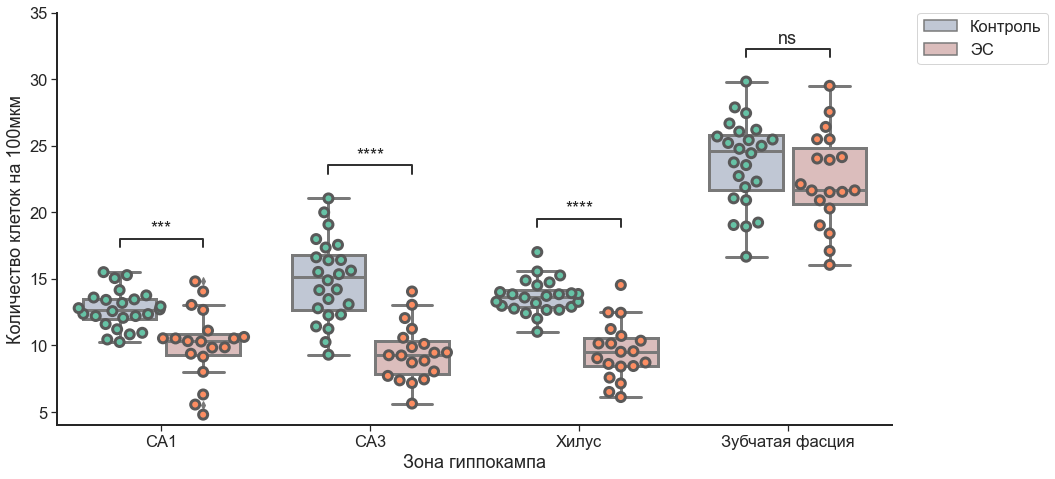

In [7]:
stat = boxplot_hue(data_wide,x='Зона гиппокампа',y='Количество клеток на 100мкм', hue='Group',
                box_pairs = [(('CA1', 'Контроль'),( 'CA1', 'ЭС')),
                (('CA3', 'Контроль'),('CA3', 'ЭС')),
                (('Хилус', 'Контроль'),('Хилус', 'ЭС')),
                (('Зубчатая фасция', 'Контроль'),( 'Зубчатая фасция', 'ЭС'))],
                figname = 'количество клеток',big_tick = 5, ylim = [4, 35], figsize=(15,7),
                loc = 'inside')

Step 4. Export data to excel 

We save the obtained values of statistical criteria into a df due to the function stat_out()

In [8]:
stat_output = stat_out(stat, index = ['CA1', 'CA3', 'Hilus', 'DG'])
stat_output

,p_val,u_stat
CA1,1.207e-06,4.270e+02
CA3,3.730e-04,3.740e+02
Hilus,8.306e-07,4.300e+02
DG,1.992e-01,2.810e+02


In [9]:
perc_table_final = data.quantile([0.25, 0.50 , 0.75])
perc_table_final

,CA1,CA3,Хилус,Зубчатая фасция
0.25,10.385655,9.379265,9.855210,20.983830
0.50,12.072990,12.261905,12.664635,23.756413
0.75,13.119945,15.437101,13.845766,25.491580


In [10]:
with pd.ExcelWriter('output_table/final_out_cell_count.xlsx') as writer:  
    perc_table_final.to_excel(writer, sheet_name='Precentile', float_format="%.2f")
    stat_output.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.3f")

Profit!